In [1]:
# Environment setup
import os
import glob
import gc
import random
import numpy as np
import pandas as pd
import warnings

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Clean display and stable behavior
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
warnings.filterwarnings('ignore')

# Colab filesystem check
base_path = "/content"
assert os.path.isdir(base_path), f"Base path not found: {base_path}"

# Find all .pkl files at the specified location
pkl_files = sorted(glob.glob(os.path.join(base_path, "*.pkl")))

print(f"Discovered {len(pkl_files)} pickle file(s) under {base_path}:")
for i, fp in enumerate(pkl_files[:20], 1):
    print(f"{i:2d}. {os.path.basename(fp)}")
if len(pkl_files) > 20:
    print(f"... and {len(pkl_files) - 20} more.")

# Quick helper for later cells
def mem_gb(obj) -> float:
    try:
        return obj.memory_usage(deep=True).sum() / (1024**3)
    except Exception:
        return 0.0

# Housekeeping
gc.collect();

Discovered 183 pickle file(s) under /content:
 1. 2018-04-01.pkl
 2. 2018-04-02.pkl
 3. 2018-04-03.pkl
 4. 2018-04-04.pkl
 5. 2018-04-05.pkl
 6. 2018-04-06.pkl
 7. 2018-04-07.pkl
 8. 2018-04-08.pkl
 9. 2018-04-09.pkl
10. 2018-04-10.pkl
11. 2018-04-11.pkl
12. 2018-04-12.pkl
13. 2018-04-13.pkl
14. 2018-04-14.pkl
15. 2018-04-15.pkl
16. 2018-04-16.pkl
17. 2018-04-17.pkl
18. 2018-04-18.pkl
19. 2018-04-19.pkl
20. 2018-04-20.pkl
... and 163 more.


In [2]:
# Load & merge daily transaction files
%%time

# Load all daily DataFrames
df_list = []
for fp in pkl_files:
    df = pd.read_pickle(fp)
    df_list.append(df)

# Merge into one DataFrame
transactions = pd.concat(df_list, ignore_index=True)
del df_list
gc.collect()

print(f"Merged transactions shape: {transactions.shape}")
print(f"Memory usage: {mem_gb(transactions):.2f} GB")

# Ensure TX_DATETIME is datetime type (adjust if column name differs)
if 'TX_DATETIME' in transactions.columns:
    transactions['TX_DATETIME'] = pd.to_datetime(transactions['TX_DATETIME'])

# Peek at the data
transactions.head()

Merged transactions shape: (1754155, 9)
Memory usage: 0.30 GB
CPU times: user 8.84 s, sys: 329 ms, total: 9.17 s
Wall time: 9.55 s


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [3]:
#Time-based customer features
%%time

def add_customer_features(df, days_list=[1, 7, 30]):
    df = df.sort_values(['CUSTOMER_ID', 'TX_DATETIME'])
    df['txn_count_cum'] = df.groupby('CUSTOMER_ID').cumcount()
    df['amount_cum'] = df.groupby('CUSTOMER_ID')['TX_AMOUNT'].cumsum() - df['TX_AMOUNT']

    for days in days_list:
        # Create left frame: current row with window start time
        left = df[['CUSTOMER_ID', 'TX_DATETIME', 'txn_count_cum', 'amount_cum']].copy()
        left['window_start_time'] = left['TX_DATETIME'] - pd.to_timedelta(days, unit='d')

        # Right frame: the same data but used for "look up" at window start
        right = left.rename(columns={'TX_DATETIME': 'lookup_time'})[['CUSTOMER_ID', 'lookup_time', 'txn_count_cum', 'amount_cum']]

        # Merge_asof to get counts/amounts as of window start
        merged = pd.merge_asof(
            left.sort_values('window_start_time'),
            right.sort_values('lookup_time'),
            by='CUSTOMER_ID',
            left_on='window_start_time',
            right_on='lookup_time',
            direction='backward',
            allow_exact_matches=False
        )

        # Subtract values at window start from current cumulative values
        df[f'cust_txn_count_past_{days}d'] = df['txn_count_cum'] - merged['txn_count_cum_y'].fillna(0)
        df[f'cust_amount_sum_past_{days}d'] = df['amount_cum'] - merged['amount_cum_y'].fillna(0)

    # Drop helper columns
    df = df.drop(columns=['txn_count_cum', 'amount_cum'])
    return df

transactions = add_customer_features(transactions)
print("Customer-level rolling features added")
transactions.head()

Customer-level rolling features added
CPU times: user 11 s, sys: 468 ms, total: 11.5 s
Wall time: 11.6 s


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,cust_txn_count_past_1d,cust_amount_sum_past_1d,cust_txn_count_past_7d,cust_amount_sum_past_7d,cust_txn_count_past_30d,cust_amount_sum_past_30d
1758,1758,2018-04-01 07:19:05,0,6076,123.59,26345,0,0,0,0.0,0.00,0.0,0.00,0.0,0.00
8275,8275,2018-04-01 18:00:16,0,858,77.34,64816,0,0,0,1.0,123.59,1.0,123.59,1.0,123.59
8640,8640,2018-04-01 19:02:02,0,6698,46.51,68522,0,0,0,2.0,200.93,2.0,200.93,2.0,200.93
12169,12169,2018-04-02 08:51:06,0,6569,54.72,118266,1,0,0,3.0,247.44,3.0,247.44,3.0,247.44
15764,15764,2018-04-02 14:05:38,0,7707,63.30,137138,1,0,0,4.0,302.16,4.0,302.16,4.0,302.16


In [4]:
# Terminal-level rolling features
%%time

def add_terminal_features(df, days_list=[1, 7]):
    df = df.sort_values(['TERMINAL_ID', 'TX_DATETIME'])
    df['term_txn_count_cum'] = df.groupby('TERMINAL_ID').cumcount()
    df['term_fraud_cum'] = df.groupby('TERMINAL_ID')['TX_FRAUD'].cumsum()

    for days in days_list:
        left = df[['TERMINAL_ID', 'TX_DATETIME', 'term_txn_count_cum', 'term_fraud_cum']].copy()
        left['window_start_time'] = left['TX_DATETIME'] - pd.to_timedelta(days, unit='d')

        right = left.rename(columns={'TX_DATETIME': 'lookup_time'})[['TERMINAL_ID', 'lookup_time', 'term_txn_count_cum', 'term_fraud_cum']]

        merged = pd.merge_asof(
            left.sort_values('window_start_time'),
            right.sort_values('lookup_time'),
            by='TERMINAL_ID',
            left_on='window_start_time',
            right_on='lookup_time',
            direction='backward',
            allow_exact_matches=False
        )

        df[f'term_txn_count_past_{days}d'] = df['term_txn_count_cum'] - merged['term_txn_count_cum_y'].fillna(0)
        fraud_diff = df['term_fraud_cum'] - merged['term_fraud_cum_y'].fillna(0)
        df[f'term_fraud_rate_past_{days}d'] = fraud_diff / df[f'term_txn_count_past_{days}d'].replace(0, np.nan)

    df = df.drop(columns=['term_txn_count_cum', 'term_fraud_cum'])
    return df

transactions = add_terminal_features(transactions)
print("Terminal-level features added")
transactions.head()

Terminal-level features added
CPU times: user 9.29 s, sys: 172 ms, total: 9.46 s
Wall time: 10.2 s


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,cust_txn_count_past_1d,cust_amount_sum_past_1d,cust_txn_count_past_7d,cust_amount_sum_past_7d,cust_txn_count_past_30d,cust_amount_sum_past_30d,term_txn_count_past_1d,term_fraud_rate_past_1d,term_txn_count_past_7d,term_fraud_rate_past_7d
9579,9579,2018-04-02 01:00:01,3440,0,16.07,90001,1,0,0,2.0,105.08,2.0,105.08,2.0,105.08,0.0,NaN,0.0,NaN
12806,12806,2018-04-02 09:49:55,3302,0,67.83,121795,1,0,0,2.0,81.72,4.0,274.25,4.0,274.25,1.0,0.0,1.0,0.0
24184,24184,2018-04-03 12:14:41,3790,0,26.82,216881,2,0,0,5.0,189.04,9.0,337.75,9.0,337.75,1.0,0.0,2.0,0.0
46284,46284,2018-04-05 16:47:41,1125,0,40.45,406061,4,0,0,2.0,121.64,13.0,499.17,13.0,499.17,-1.0,-0.0,3.0,0.0
58807,58807,2018-04-07 06:05:21,1125,0,48.39,540321,6,0,0,9.0,416.86,23.0,956.48,23.0,956.48,1.0,0.0,4.0,0.0


In [5]:
# Time-based train/test split
%%time

# Inspect time range to choose a sensible cutoff
print("Data covers from", transactions['TX_DATETIME'].min(), "to", transactions['TX_DATETIME'].max())

# Set split date — adjust if you want a different test period
split_date = pd.Timestamp('2018-09-01')

# Train = all transactions up to and including split_date
train_df = transactions[transactions['TX_DATETIME'] <= split_date].copy()

# Test = all transactions after split_date
test_df = transactions[transactions['TX_DATETIME'] > split_date].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")

# Check fraud rates in each
fraud_train = train_df['TX_FRAUD'].mean()
fraud_test = test_df['TX_FRAUD'].mean()

print(f"Fraud rate in train: {fraud_train:.4f}")
print(f"Fraud rate in test:  {fraud_test:.4f}")

Data covers from 2018-04-01 00:00:31 to 2018-09-30 23:59:57
Train shape: (1466282, 19)
Test shape:  (287873, 19)
Fraud rate in train: 0.0083
Fraud rate in test:  0.0088
CPU times: user 983 ms, sys: 35.8 ms, total: 1.02 s
Wall time: 1.03 s


In [6]:
# Feature preparation & imbalance handling
%%time
from sklearn.model_selection import train_test_split

# Target variable
y_train = train_df['TX_FRAUD']
y_test = test_df['TX_FRAUD']

# Feature set — drop IDs, datetime, and fraud scenario (leaks label)
drop_cols = ['TRANSACTION_ID', 'TX_DATETIME', 'TX_FRAUD', 'TX_FRAUD_SCENARIO']
X_train = train_df.drop(columns=drop_cols)
X_test = test_df.drop(columns=drop_cols)

print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

# Class imbalance ratio
fraud_ratio = y_train.mean()
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
print(f"Fraud ratio in train: {fraud_ratio:.4f}")
print(f"Suggested scale_pos_weight: {scale_pos_weight:.2f}")

Train features shape: (1466282, 15)
Test features shape: (287873, 15)
Fraud ratio in train: 0.0083
Suggested scale_pos_weight: 119.84
CPU times: user 1.52 s, sys: 262 ms, total: 1.78 s
Wall time: 1.78 s


In [7]:
# Fix dtypes for XGBoost
for col in ['CUSTOMER_ID', 'TERMINAL_ID']:
    X_train[col] = X_train[col].astype('category').cat.codes
    X_test[col] = X_test[col].astype('category').cat.codes

for col in ['TX_TIME_SECONDS', 'TX_TIME_DAYS']:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

print(X_train.dtypes)

CUSTOMER_ID                   int16
TERMINAL_ID                   int16
TX_AMOUNT                   float64
TX_TIME_SECONDS               int64
TX_TIME_DAYS                  int64
cust_txn_count_past_1d      float64
cust_amount_sum_past_1d     float64
cust_txn_count_past_7d      float64
cust_amount_sum_past_7d     float64
cust_txn_count_past_30d     float64
cust_amount_sum_past_30d    float64
term_txn_count_past_1d      float64
term_fraud_rate_past_1d     float64
term_txn_count_past_7d      float64
term_fraud_rate_past_7d     float64
dtype: object


In [8]:
# Baseline XGBoost model
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Baseline model setup
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Train
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[284783    543]
 [   151   2396]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9981    0.9988    285326
           1     0.8152    0.9407    0.8735      2547

    accuracy                         0.9976    287873
   macro avg     0.9074    0.9694    0.9361    287873
weighted avg     0.9978    0.9976    0.9977    287873

CPU times: user 1min 7s, sys: 146 ms, total: 1min 7s
Wall time: 38.8 s


In [9]:
# Threshold tuning
%%time
from sklearn.metrics import precision_score, recall_score

# Get predicted probabilities for the positive class
y_proba = xgb_model.predict_proba(X_test)[:, 1]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5,
              0.6, 0.7, 0.8, 0.9]

print(f"{'Thresh':>6} {'Precision':>10} {'Recall':>10}")
for thr in thresholds:
    preds_thr = (y_proba >= thr).astype(int)
    prec = precision_score(y_test, preds_thr)
    rec = recall_score(y_test, preds_thr)
    print(f"{thr:6.2f} {prec:10.4f} {rec:10.4f}")

Thresh  Precision     Recall
  0.10     0.5683     0.9713
  0.20     0.6622     0.9603
  0.30     0.7249     0.9537
  0.40     0.7712     0.9462
  0.50     0.8152     0.9407
  0.60     0.8569     0.9336
  0.70     0.8989     0.9285
  0.80     0.9335     0.9207
  0.90     0.9622     0.9085
CPU times: user 2.76 s, sys: 2.9 ms, total: 2.76 s
Wall time: 2.65 s


In [10]:
#Apply custom threshold & re-evaluate
%%time
from sklearn.metrics import confusion_matrix, classification_report

# Choose your threshold here
chosen_threshold = 0.4  # change this to whatever you prefer

# Apply threshold
y_pred_custom = (y_proba >= chosen_threshold).astype(int)

# Evaluation
print(f"Using threshold = {chosen_threshold}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom, digits=4))

Using threshold = 0.4

Confusion Matrix:
[[284611    715]
 [   137   2410]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9975    0.9985    285326
           1     0.7712    0.9462    0.8498      2547

    accuracy                         0.9970    287873
   macro avg     0.8854    0.9719    0.9241    287873
weighted avg     0.9975    0.9970    0.9972    287873

CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 123 ms


<Figure size 1000x600 with 0 Axes>

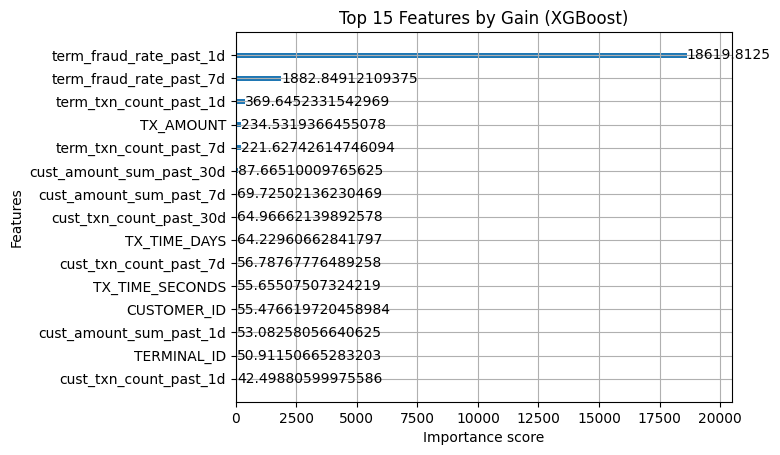

In [11]:
# Fast feature importance from XGBoost
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot top 15 most important features
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.title("Top 15 Features by Gain (XGBoost)")
plt.show()